# Import relevant libraries

In [114]:
# torch libraries to implement the NN model
import torch
import torch.nn as nn
import torch.functional as F

# torchvision modules to download, modify, manipulate the data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid 

# ever-used libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Defining hyperparameters

In [97]:
n_epochs = 30
lr = 0.001
momentum = 0.9
batch_size = 16

# Defining utility functions

In [98]:
def grid_im_show(dataloader, cmap='Greys'):
    """
    A function to plot the random batch of 
    the data/
    """
    plt.figure(figsize=(16, 8), dpi=180)        # creates a figure container to add subplots to
    plt.tight_layout()
    for i, img in enumerate(dataloader):
        
        plt.subplot(int(batch_size/4)+1, 4, i+1)
        img_trans = img.numpy().transpose((1, 2, 0))       # changing the Pytorch channel order, channel-first, to 
                                                           # to the default of matplotlib, channel-last
        plt.margins(0.5, 0.5)
        plt.imshow(img_trans, cmap=cmap)

In [99]:
def evaluate_model(model, dataloader):
    model.eval()                                # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():                      # torch.no_grad spaces up the memory when no differentiation is needed
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)   # the model returns a bunch of probabilities and we take the argmax.
            corrects += (preds == targets.data).sum()  # if the prediction is correct, add to the counter
    
    return 100. * corrects / len(dataloader.dataset)

# Pre-defining transformations of the test and train datasets

In [100]:
# transform applied to the training dataset including Data Augmentation to improve generalization
transforms_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
        transforms.RandomRotation(20),
        transforms.Normalize((0.1307,), (0.3081,))])


# transform applied to the training dataset
transforms_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])


# Downloading the train and test datasets

In [101]:
data = datasets.MNIST(root='./.',
                     train=True,
                     download=False,
                     transform=transforms_train)

test = datasets.MNIST(root='./.',
                     train=False,
                     download=True,
                     transform=transforms_test)

# Train and test DataLoaders

In [102]:

train_dl = DataLoader(data, 
                     batch_size=batch_size,
                     shuffle=True,
                     num_workers= 8)

test_dl = DataLoader(test, 
                     batch_size=batch_size,
                     shuffle=False,
                     num_workers= 8)

train_iter = iter(train_dl)

In [103]:
count_dict = {}
for i in train_dl.dataset.class_to_idx.values():
    count_dict[i] = 0
    
for i in train_dl.dataset.targets.numpy():
    count_dict[i] += 1


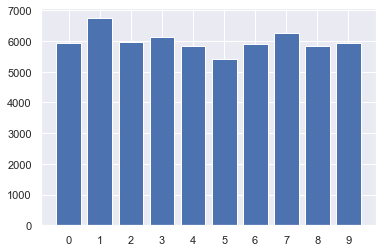

In [115]:
plt.bar(train_dl.dataset.class_to_idx.values(), count_dict.values())
plt.xticks(np.arange(0,10));

# Plotting a batch of train images

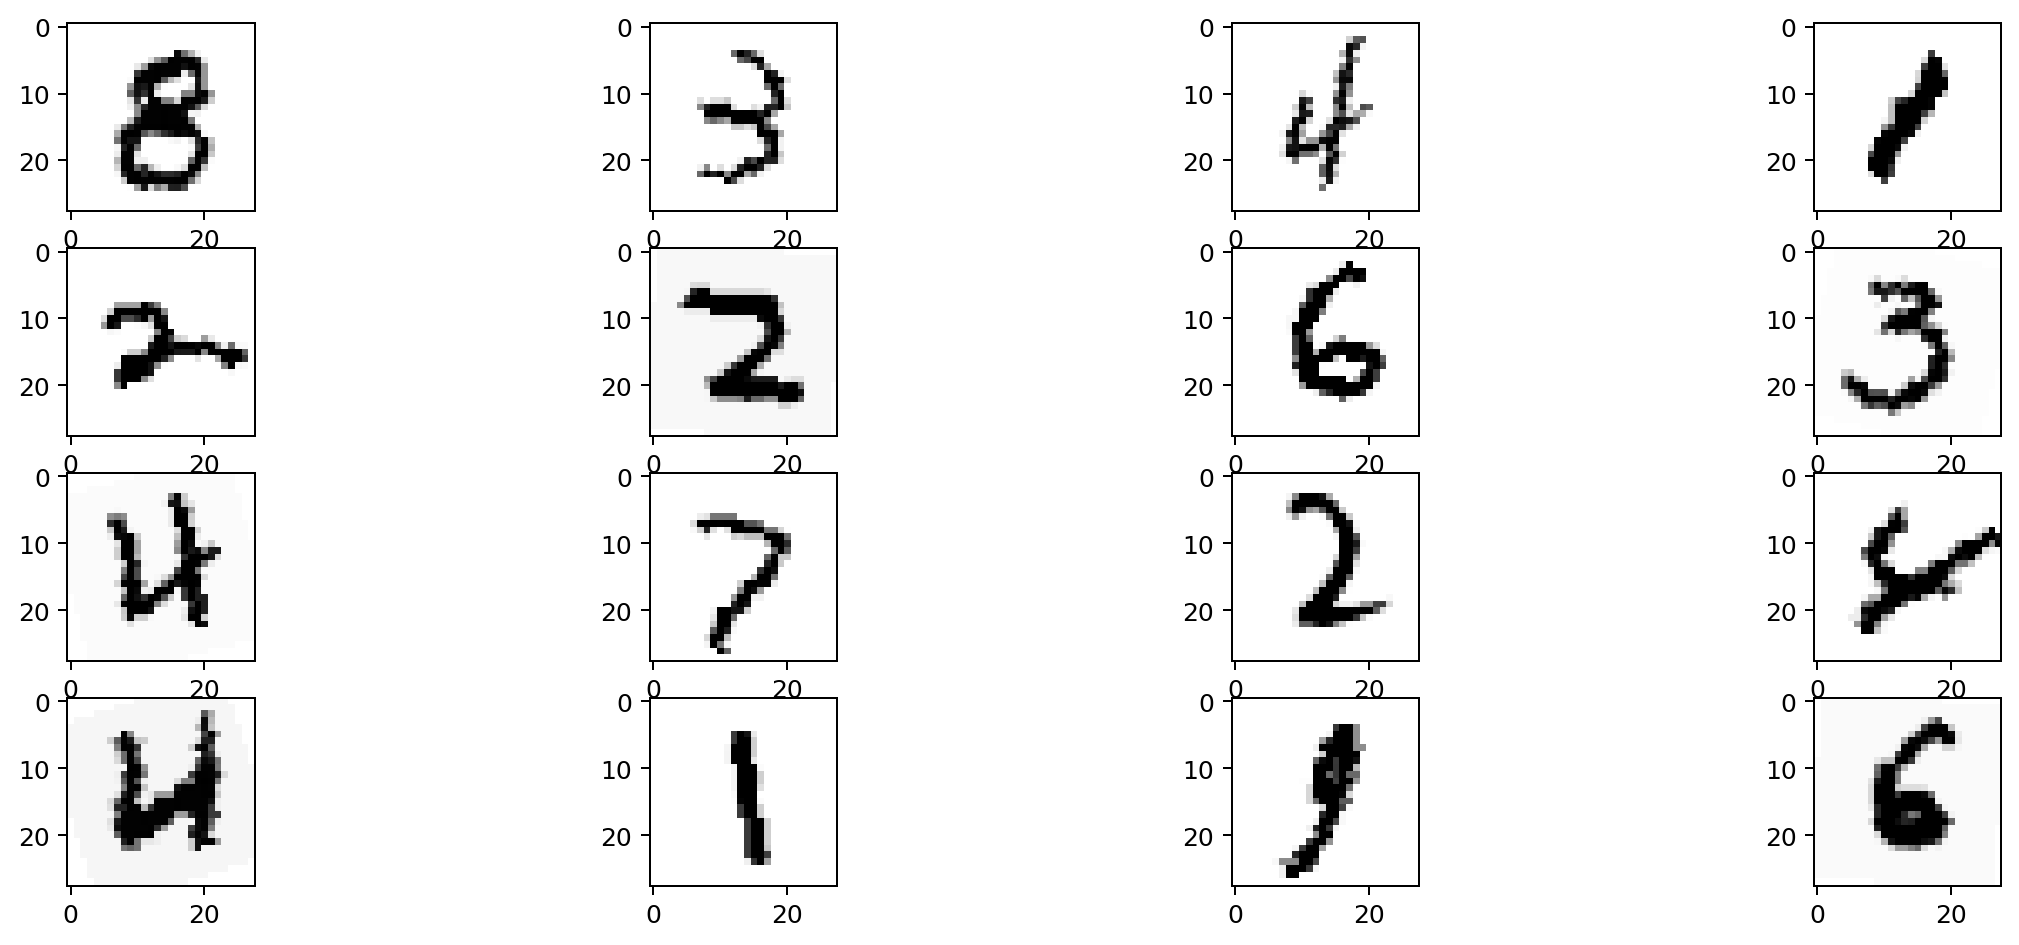

In [105]:
imgs, labels = next(train_iter)
grid_im_show(imgs, cmap='Greys')

In [106]:
# Creating the CNN class with 2 Conv layers, one fully connected layer.
class MNIST_CNN(nn.Module):
    
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, padding='same')
        self.norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxp1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=7, padding='same')
        self.norm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxp2 = nn.MaxPool2d(2)
        
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.maxp1(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu2(out)
        out = self.maxp2(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)
        return out
    
    

In [107]:
model = MNIST_CNN()       # Instantiating the Class

In [108]:
# instantiating the optimizer and the loss function

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss = nn.CrossEntropyLoss()

In [109]:
losses = []
for e in range(30):                                 # run the for loop for the number of epochs
    for i, (imgs, labels) in enumerate(train_dl):
        
        outputs= model(imgs)                        # returns the outputs
        l = loss(outputs, labels)
        optimizer.zero_grad()                       # gradients should be set to zeros in every iterartion             
        losses.append(l.item())
        
        l.backward()                                # calculates the gradients
        optimizer.step()                            # step forward using the calculated gradients and SGD formula
        
        if (i+1) % 3750 == 0:
            print(f'episode {e+1}, loss {l.item():.5f}')

episode 1, loss 0.22589
episode 2, loss 0.00555
episode 3, loss 0.08233
episode 4, loss 0.00886
episode 5, loss 0.02406
episode 6, loss 0.00183
episode 7, loss 0.01042
episode 8, loss 0.00265
episode 9, loss 0.00930
episode 10, loss 0.02885
episode 11, loss 0.00754
episode 12, loss 0.00015
episode 13, loss 0.16853
episode 14, loss 0.03245
episode 15, loss 0.00312
episode 16, loss 0.00029
episode 17, loss 0.00678
episode 18, loss 0.01662
episode 19, loss 0.00257
episode 20, loss 0.00294
episode 21, loss 0.00016
episode 22, loss 0.00020
episode 23, loss 0.01022
episode 24, loss 0.00250
episode 25, loss 0.00119
episode 26, loss 0.08935
episode 27, loss 0.00081
episode 28, loss 0.00504
episode 29, loss 0.03576
episode 30, loss 0.00023


# Calculating accuracies

In [110]:
print(f' The training accuracy is {evaluate_model(model, train_dl):.2f}%')

 The training accuracy is 99.46%


In [111]:
print(f' The testing accuracy is {evaluate_model(model, test_dl):.2f}%')

 The testing accuracy is 99.44%
